# Direct mixture separation

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file_1 = "../data/airco.wav"   # specify sound location of first mixture component
sound_file_2 = "../data/leaves.wav"      # specify sound location of second mixture component
fs_desired = 8000                   # specify desired sampling frequency

# parameter loading
param_file_1 = "inferred_values/airco_AR20.h5"
param_file_2 = "inferred_values/leaves_AR20.h5"

# inference and modelling
AR_order = 20                         # order of auto-regressive model
iterations = 3                       # number of iterations for variational message passing
Λ_meas = 1e10                        # assumed precision of measurement noise
;

## Load and preprocess data

In [3]:
# load and process first mixture component
x_1, fs_1 = wavread(sound_file_1, format="native")
fs_1 = Int(fs_1)
x_1 = x_1[0*fs_1+1:3*fs_1]
x_1 = resample(x_1, fs_desired/fs_1)
x_1 = 20*x_1/var(x_1)

# load and process second mixture component
x_2, fs_2 = wavread(sound_file_2, format="native")
fs_2 = Int(fs_2)
x_2 = x_2[18*fs_2+1:21*fs_2]
x_2 = resample(x_2, fs_desired/fs_2)
x_2 = 100*x_2/var(x_2)

# Combine signals through simple addition
x_tot = x_1 + x_2

# create time axis
t = collect((1:length(x_tot))/fs_desired)

# create audio players for demonstration
audioplayers(x_1, x_2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQA3ciI4gWE6OZOvsbksr7k5BEaJOWYRAjqjBC+6USUuOdnlrbp2mKu5RE7nuioAEryRdV48GavLPKRIwbwEwqq8PrY2PCR3FDz4P2o6Mj+4vCqFA70Z00K8ZN7hPCWDTj1B5hM9NJqzPMVr6LyqDC+9HdF4vL85SD0pZu48tr4MvUqeAL1Hb7e8c2qFvFGDzLxuiwa8ZHd3vKJHeLnUs6w8a66du/SXAD2lZY08nhknu0eC5Lyxvxq60KCtPOE0Lj2AjyA9t3wQPQkjgTwbFNW8DdIvvbeUFryr2gI8lfw3vFsGAr25JHk7RUbUPPOFyjw0nWy8a9dkvfifBr0dsXs8g0QtPZp/Kz3I49+7T6Yevc5nmrsk1ZM9/RHHPerqZz1aHC29kgiVvQZwarzRy4w68WJ7vDScXb1ig569hfasvXBR4Lw8uA49XIInPdezZjuaYF+91bjAvRH9hr0h6HC8xZrKPFv64DyaNjw9UhOrPQRjnj2phZg8eh18vAD5DryQZjI9rg+hPQ22gT00xmc74D+RvVZ18L2925+95iNhvQQ7GL1REI28NQmGvIbMO70q+Rm9e/WIvNUqED1lX2o9qA2EPRx30zwsxH89KJfLPWLz3z2kRKg9P8AEPSIRrjwLNi09uD1jPa9EVD1ecIo9dfKxPYhSoD1wuWs9ICN6PT9pHT15b326/rW+vNCEBL13usC8sMJAvcWYo73nPb+9D630ve83E76b9+q9BpOrvU3EoL1jFAG+Ks4pvsPzOL7SrBK+SlG4vXliXb26xXm9bBy6vPorTbsthIw8vf+dPUKd5j2kEYM9U5G/PFFhXj0Nf8Y9uYjVPXnw2z2AaKs9flgVPRe67zyW4SE9SCBzPeaOkjz0Vsc8mJUDPWlnv7t3h7i8dMIFPK/2mjwqnwY9P/qYPSaPzD1qAM09aB3sPadNnT3vUpA9PqWZPaJKsj1i4e890zHYPRR5Az4uIOk9pNghPWq4vbiH72y8h0bkvGhNTb04w/68jrEVvbBSqb0DGvW95C8uvk3hJ76Clvu9ZN2SvebEs7ymiqq8o9rCvGkkB72Zxl69DHwOvR7MDD3FffI8DwRXPJ9isLwdU5q8RyCxu/Pl+byMij07G8kWPM6g1bzSjqS8KNo3vaV3K7209Qu8k5DkuwCfLL2SVc+9aZTMvReIcr0A0hq9D8U6vZbf0L2AIRS+mAHpvRgAqb2nIJ+983epvZJTSb2oFzO8BmHYPDKESj372x49gVEVvJ/ZlbwJ7A89+dmgPacjBj6u/RU+lj8ePlcrJz5AAyU+PAMPPnq+8T1v1KM9grW9PX2kuz3snaw962gUPR91H71Nkfi9jscKvu/yqb03Q229BQ8NvXYR37yas6S93tQRvknALb6N3qa9q18jPIM4Tj26+GI9l78oPJpsILwuP+K7XLWHvNO/CD3oG7U9XFWuPSkAPz3aLwA9tJenvA3l/rwbUZa8BMDxvJ6hAb1aWK+980rzvWv24r1VZvC9uS3EvfPXhr1KzQS9ZmNLvaViIr1ESsW8hEHAvIMcAzzeg1q84RXlvO0XZ7uPpRG7wvSYvLb7B7wclms7+u3VPEZZkT1O16k90hBYPc9tDD36vWM7TTGrvAJJ17zZG7y85VRovD/eGL13vou97zBlvd1/8ruTDwM9WiKVPUDrpj049607oZVQvIYkOT27ecc9hA4jPr4hMT6Pvxs+ETsgPkylKj5ZoiQ+Mz1OPqE2Tj6uhyE+PRsSPqBAqj1eenw9Ce3ZPQLvuT3I7Lg8E0lBvLAAmL0gvtq9IBeFvbWkHb2SIFC9H/ofvc2+yL35Sh2+tPIlvsBQJr7MWdW9m+MmvR3lzrxDr4K7l+39uwWy1rxJWsA8Ef8jPeJtqD39NAs+OkECPkXEzT0tXr49YrwLPTGtcjytWsU8g8PQPHTvrzuQvFG8uVicvMQ9gr2g9re9pysHvqyeFr798uC9ms+gvRdvkr3Fa869PujUvUTt4r3PRfO9cOnrvfSd1L0GXgm+Z4wDvkK+pL19HRO9O/sbvVYIb70N5F29LMYrvZh8m7z/pwM8vNIYPYfsLj2l6Fg9jQQ2Pc9oEz2OzDA8r4CFPEjPnbwnZWO90gL3PC8N9T2/Z+o97TtVPaecAL0h0LS9govNvWVg4bwA2nk9ATn5PeUn0T03kqE9wT9FPfOqiT2KLyA+6CtZPpLoLz5KlA0+Tb8BPsAc0z3gxxQ+ULc3PsZyCz5tHSE9bGTgOwrvvDxBBts8ZfO5PErmH7xWO6W93fMMvoI/7L0TMYm988ZQvcEl6Lxb3am97N7xvWO26r05EMm9rtfZvUjJx71Si9O9yfOUvaJqUr3RIpW9jk2Yvd4por0+Qiq9XlqJO/ahlDzq1Is8yf8hvRNujL22HBm9mXfuPJOKij0uyxM9fIyVvU3aFb572gu+OcunvcMvd7yseR68xmIzvVA1h70NrJu9FsTLu9y+QD1bIoY9TZk7Pf+6kDzUBD49GUCAPVfZmj2kboI9+NHAPf3L2j37iek9hG4KPmvI8D1hzuw9A//yPRtO4D03XsY9fZPCPUaZnz0mO4k8UR2SPG9t+ruG47k74lDYPLsFGDt3Poe83VFsvTO/VL2mdD29h+k+vVxJkr3RnIu9k5d0vY7nArz+S6U8dBMGO9jISL2cnXK9nTwJvaUX8TxTh8k9W6fmPVmQ0D2OmJc9QEmDvB159Lyf7Em8j9uEPM82Jr3PiPS8tH1xvfn06b032mm90GiJvbMI6b37Vwi+AZvuvaZOsr2fcwm97mcEvYLenL3iS7S9qQGhvXLmAb2YPHw6yE14PVm/zz3j5lc9t3MdPZKL4DwSz5A8pu5wPby1xT34/Kw97ZZXPbbJGz1JQy09E+o+PVaeFD2OANE8MWLVu4mnRTxLeZK8y6qJvQbRwL0mPba94MTNvH3AjDwMJDG651GCvdSexL1t72e9oSUOPe4llz0WjBs91Yu8vLeBnrwzDDI8rD+YPXL6JD79IyE+TSiEPYF3DT2b/a49pWXwPcSVoD1WDjw9sbVivK5uCr07cGE8RcIgPWVhSzzCKAU8LsoNPYubkT12JoE9hK7dPOWC77zDF0K9AP6yu7jjsz3clZo9PX3IPMGbCr2da6C96HsGvLrXYT0McbM9UneLPWm4abtrKeq7pyBWvUq4jL0tWkm9AkcOvb0vcLyMjju9kdPEvaVcA77M8AK+qRa/vXxT4ryoo3K7CaqIvZM6HL5WRja+K4kfvl/ijL0hFsU8WKkKPQ2zo7xRcKK9NVe0vYfRVb0KyMi78NvaO2aPOrws3AC9gHaCu6bAGT0gZY49Gr6wPe6ofj0gDS49UR5FPT3vID0ugYs8BU2yOyW23LwnRse82rhrvIHt8jyEFXE95Rx2PcbCXD1VNzU7LxaHvWHAr726ICq9lAumPHSQgj2TCCQ9+iuYOz1N37vJGwq8czSBPbl9Cz6ZEwU+qt6RPd3GFT3koTk8xJYEPaprrz03NcU9H9nAPBTdyDzKAC09feJYPecrij0L8ME9x1PgPWdRuD3CKWk9gQ3gPHL2sztNj1s9HVV3PTeRuj1dAPA9JEDFPTAeHj3ChD46f94UO8wEB71qNwG9IVFlvXRcYb0uA4C9GKeRvXq5Sr3SSrK93dUCviqCGr4WGrW9dyhGvYmq6ryQUL290twnvsLaEb4yzgG+wfUAvv0o7b2WyRS+/5rwvcm6Cr4o0Dy+u68dvu7JKb5s8Bu+4oXKvQmOsLx2S8W8dTZyvY+E170zho69U9JGO5nBhj2dI/49PocNPnrfCD4/kgM+FcDePXmH4j2qL/s9Ip0GPgJN6T3q8No94pkCPlcv+j3vdLo9DrCbPaDIsj3D5

## Visualize data

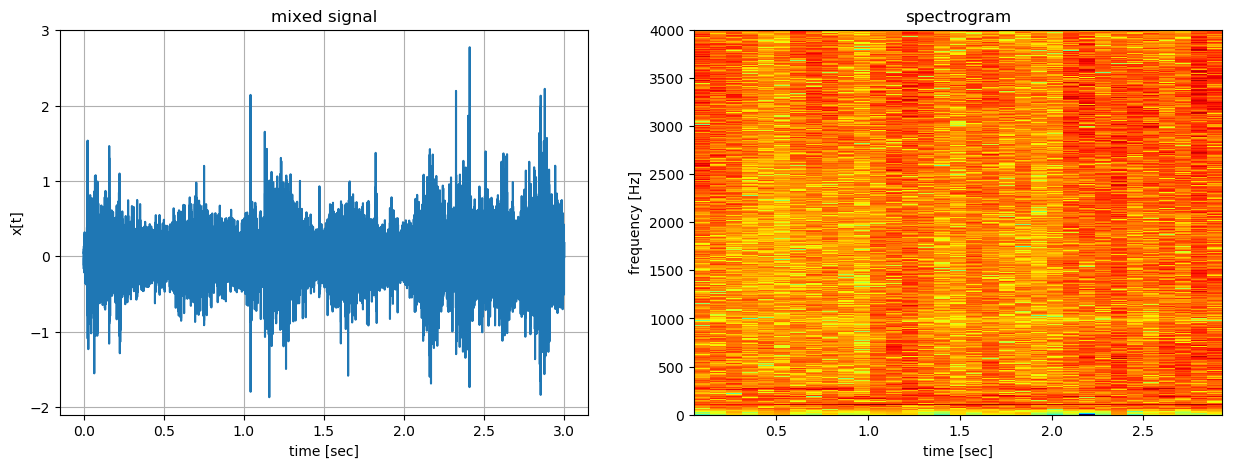

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("mixed signal"), ax[2].set_title("spectrogram")
;

## Load parameters

In [5]:
params_1 = h5read(param_file_1, "parameters")
params_2 = h5read(param_file_2, "parameters")
;

## Create generative model and algorithm

In [6]:
# create factor graphs
fg = FactorGraph()

# AR node (source 1)
@RV γ1 ~ ForneyLab.Gamma(params_1["a_gamma"], params_1["b_gamma"])
@RV θ1 ~ GaussianMeanPrecision(params_1["mean_theta"], params_1["precision_theta"])
@RV Sprev1 ~ GaussianMeanPrecision(placeholder(:μ_Sprev1, dims=(AR_order,)), placeholder(:Λ_Sprev1, dims=(AR_order, AR_order)))
@RV S1 ~ LAR.Autoregressive(θ1, Sprev1, γ1)

# AR node (source 1)
@RV γ2 ~ ForneyLab.Gamma(params_2["a_gamma"], params_2["b_gamma"])
@RV θ2 ~ GaussianMeanPrecision(params_2["mean_theta"], params_2["precision_theta"])
@RV Sprev2 ~ GaussianMeanPrecision(placeholder(:μ_Sprev2, dims=(AR_order,)), placeholder(:Λ_Sprev2, dims=(AR_order, AR_order)))
@RV S2 ~ LAR.Autoregressive(θ2, Sprev2, γ2)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x1 ~ DotProduct(d, S1)
@RV x2 ~ DotProduct(d, S2)

@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x1 + x2 + v
placeholder(y, :y)


ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1675865759134827341 -->
 1675865759134827341 
 
 Gam 
 gamma_2 
 
<!-- 7754981101580802532 -->
 7754981101580802532 
 
 clamp_6 
 
<!-- 1675865759134827341--7754981101580802532 -->
 1675865759134827341--7754981101580802532 
 
 clamp_6 
 1 out 
 3 b 
 
<!-- 11087353641488959486 -->
 11087353641488959486 
 
 clamp_5 
 
<!-- 1675865759134827341--11087353641488959486 -->
 1675865759134827341--11087353641488959486 
 
 clamp_5 
 1 out 
 2 a 
 
<!-- 8155361116970824217 -->
 8155361116970824217 
 
 dot 
 dotproduct_1 
 
<!-- 16302393768887107204 -->
 16302393768887107204 
 
 clamp_9 
 
<!-- 8155361116970824217--16302393768887107204 -->
 8155361116970824217--16302393768887107204 
 
 clamp_9 
 1 out 
 2 in1 
 
<!-- 8096246078218773864 -->
 8096246078218773864 
 
 AR 
 autoregressive_1 
 
<!-- 8155361116970824217--8096246078218773864 -->
 8155361116970824217--8096246078218773864 
 
 S1 
 1 y 
 3 in2 
 
<!-- 16103442379449137219 -->
 16103442379449137219 
 
 clamp_3 
 
<!-- 6290904984558686375 -->
 6290904984558686375 
 
 clamp_11 
 
<!-- 15914430659967957675 -->
 15914430659967957675 
 
 placeholder_μ_Sprev1 
 
<!-- 8957754487395280443 -->
 8957754487395280443 
 
 placeholder_y 
 
<!-- 17041499526437205062 -->
 17041499526437205062 
 
 + 
 addition_2 
 
<!-- 8957754487395280443--17041499526437205062 -->
 8957754487395280443--17041499526437205062 
 
 y 
 1 out 
 1 out 
 
<!-- 16685114304717192197 -->
 16685114304717192197 
 
 Gam 
 gamma_1 
 
<!-- 8096246078218773864--16685114304717192197 -->
 8096246078218773864--16685114304717192197 
 
 γ1 
 1 out 
 4 γ 
 
<!-- 6995708493891314252 -->
 6995708493891314252 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 8096246078218773864--6995708493891314252 -->
 8096246078218773864--6995708493891314252 
 
 Sprev1 
 1 out 
 2 x 
 
<!-- 3405033302459174005 -->
 3405033302459174005 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 8096246078218773864--3405033302459174005 -->
 8096246078218773864--3405033302459174005 
 
 θ1 
 1 out 
 3 θ 
 
<!-- 18180640596687007163 -->
 18180640596687007163 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 1985259616282547895 -->
 1985259616282547895 
 
 clamp_7 
 
<!-- 18180640596687007163--1985259616282547895 -->
 18180640596687007163--1985259616282547895 
 
 clamp_7 
 1 out 
 2 m 
 
<!-- 7723659547901484657 -->
 7723659547901484657 
 
 clamp_8 
 
<!-- 18180640596687007163--7723659547901484657 -->
 18180640596687007163--7723659547901484657 
 
 clamp_8 
 1 out 
 3 w 
 
<!-- 15909380692437305232 -->
 15909380692437305232 
 
 clamp_1 
 
<!-- 16685114304717192197--15909380692437305232 -->
 16685114304717192197--15909380692437305232 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 13959585643607734300 -->
 13959585643607734300 
 
 clamp_2 
 
<!-- 16685114304717192197--13959585643607734300 -->
 16685114304717192197--13959585643607734300 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 18097110264577283669 -->
 18097110264577283669 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 17041499526437205062--18097110264577283669 -->
 17041499526437205062--18097110264577283669 
 
 v 
 1 out 
 3 in2 
 
<!-- 4051220532465401978 -->
 4051220532465401978 
 
 + 
 addition_1 
 
<!-- 17041499526437205062--4051220532465401978 -->
 17041499526437205062--4051220532465401978 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 6386317064887502023 -->
 6386317064887502023 
 
 placeholder_Λ_Sprev1 
 
<!-- 18097110264577283669--6290904984558686375 -->
 18097110264577283669--6290904984558686375 
 
 clamp_11 
 1 out 
 2 m 
 
<!-- 3237626759773682515 -->
 3237626759773682515 
 
 clamp_12 
 

In [7]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S1, Sprev1, x1, S2, Sprev2, x2, ids=[:S1 :Sprev1 :x1 :S2 :Sprev2 :x2])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
;

## Perform inference

In [8]:
# priors
current1_μ_Sprev = randn(AR_order)
current1_Λ_Sprev = tiny*diagm(randn(AR_order))
current2_μ_Sprev = randn(AR_order)
current2_Λ_Sprev = tiny*diagm(randn(AR_order))
current1_μ_x = randn(1)
current1_Λ_x = tiny
current2_μ_x = randn(1)
current2_Λ_x = tiny

# placeholders for predictions
x1_μ_pred = Float64[]
x1_Λ_pred = Float64[]
x2_μ_pred = Float64[]
x2_Λ_pred = Float64[]

# progress bar
p = Progress(length(x_tot), 1, "Observed ")

# initialize marginals and data dictionary
marginals = Dict()
data = Dict()

# loop through signal samples
for sp in 1:length(x_tot)
    
    # update progress bar
    update!(p, sp)
    
    # update marginals
    marginals[:θ1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_1["mean_theta"], w=params_1["precision_theta"])
    marginals[:γ1] = ProbabilityDistribution(Univariate, Gamma, a=params_1["a_gamma"], b=params_1["b_gamma"])
    marginals[:Sprev1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current1_μ_Sprev, w=current1_Λ_Sprev)
    marginals[:x1] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current1_μ_x, w=current1_Λ_x)
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_2["mean_theta"], w=params_2["precision_theta"])
    marginals[:γ2] = ProbabilityDistribution(Univariate, Gamma, a=params_2["a_gamma"], b=params_2["b_gamma"])
    marginals[:Sprev2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=current2_μ_Sprev, w=current2_Λ_Sprev)    
    marginals[:x2] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=current2_μ_x, w=current2_Λ_x)
    
    # perform VMP iterations
    for it = 1:iterations
        
        # update data dictionary
        data = Dict(:y => x_tot[sp],
                    :μ_Sprev1 => current1_μ_Sprev,
                    :Λ_Sprev1 => current1_Λ_Sprev,
                    :μ_Sprev2 => current2_μ_Sprev,
                    :Λ_Sprev2 => current2_Λ_Sprev)      
        
        # perform inference
        data, marginals = step_all!(data, marginals)
        
        # update current parameters
        current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev1])
        current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev1])
        current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev2])
        current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev2])
        current1_μ_x = ForneyLab.unsafeMean(marginals[:x1])
        current1_Λ_x = ForneyLab.unsafePrecision(marginals[:x1])
        current2_μ_x = ForneyLab.unsafeMean(marginals[:x2])
        current2_Λ_x = ForneyLab.unsafePrecision(marginals[:x2])
        

    end
    
    # update current parameters
    current1_μ_Sprev = ForneyLab.unsafeMean(marginals[:S1])
    current1_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S1])
    current2_μ_Sprev = ForneyLab.unsafeMean(marginals[:S2])
    current2_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S2])
    
    # save predictions of separation
    push!(x1_μ_pred, current1_μ_x)
    push!(x1_Λ_pred, current1_Λ_x)
    push!(x2_μ_pred, current2_μ_x)
    push!(x2_Λ_pred, current2_Λ_x)    
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:05:115:10


## Airco sound

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBJ90o922IpvbLjK76TKso9K1sgvuPnBD0N0gk+EI31vXWL071QGJu8wLEovvDdDT5sOwu+/6SJPp11S71C/ie9aXgIO5YCyj3CsGg8Ll12PeS+W77D7Uw9+KDsPd3BD75nwra9iRcMPv7KjT6PozC9P4f1vf34uDwgbgy+cb5zvdv2kr0dC569gFhIPWQeGz5JTxO+gDy+Pa0vB77JOaM+51JKPdU6zj2cF+U9Rk0KvrJ4Hj0B7ig9VKhaPF4KXrwTsAa8XV58PcWUWL5xfhG+tzjiPNqjbb05IqO7mJ0RPp2zsb0phoq9iyqHPLR8rz0xoaE9VFNgvr3MrL1cGiK8y8WQPFlirr1V8ey9pHM+PgSzYr5W2FU+Tkl9PbcGMz5/5Sy973JKPvnpB766Eg0+rukVvYlZBr6/dTs+LRu5vrC2ij77b+O9EYtwvQwao71viDy+S6JzvamfgT2f6Ri9TrZqPQNJJL61J+a70WCZvUhAPD6Xz6s9XKAJPOIESj06ngM+z5CtPYjHGL7CW00+y6VwPY2Fir7FeDy+Z+FcvXAnqT3/J9G9pRHpPU3Ojr4T66o9djHqPTTll77lKWI+Jr2pvYCXuT1XLfk9D7eQPvkeGT6+cHY93/wlPtcKLb5QGwE+714WPhOpjr7t/zA+23YsPdsSCz5s2hq+9BKyvbx0Tz4I+yW+3nabPiL6KD46ogy+dqiBvGZeHr4QAsM99EWOvhalbL35rwC9MguXvsi9Lz4w9p++o5XwPT1gw76yD/K794pkvg2kgr3oND6+m4MqvWIlmb1EFAi+6aN1PUEATT5xqQm9FztUPpVhjD34OTU+F+CgvX0o/bynl8Q+n96KPqe+VD6IabC+GpRsPnS6Ij83/ei+tTaYPWjknL5TTgC/QF+BP1a4Nr5kegW/zUPqPrTksz6fhEi/Q61OP0lV474Yqs4++1ECPr8+0b23/QO/6DHDP8YJGb9GhTi9ptI0PwhcqL4X7ZS954DlvugMUz5MEGO9BBDEPTw3ub4uhcc9quSLv4eTxD9Oemq/kzC5vs4WC74POyw/8/xGv4VtSj+mOUS/jFKcPoABKT55Fdy83YvavaoyJ76G2a4+FGEDv6YuYz+kVhS/XzbmPvbXsb50u8A9eNLGvnl1Ab6B0rs+zZuCvrycFz51Apm+t8vRvOPfwT7a4e++PNt2vkJmJT/J5p2/5pNsPspU2z6elhi+9RBQvyIFHz3bLt480tPbPo89PL5T6kY/wAtmv31sgD0JORM/sCO8vupJwj7SPq+9jGK+PmNAh7xlaJk+8rikvRNo/Tu6RIo9M5I5PWdQnT4hgFU9ELaTPsF3j723OeW9PCyvvcJVbrxr2i688IDlPZW/uL51q6G7Awv3vgjC6L2czlS9Neo+PmWilr3Yw1E+/A+NPmwQDr+DABc+3zPxvmKmqz5Qv4o9ZJraPvW/q70RKeW93FGZPCmyOT4gf7C99qWnPrLjWL6dpTa+LpGQvfF9sb6PnDy+Rw1NPmm4vL7lADk+p24svjJyOb6Mepw+F3wnvurjm70I+yy9IuiiPDGK+z0zbqs9DsGHPRM0Ur5USEg9l1Liun5SIL0zwm29tVIXPjq+Ib5O3Qk+nNa4vew6Dj45TBu+bWcbO3FMt71lQXI+2raFPAHPqzzZF1i91PmRPXPJsr270FO9hlYev1UiCz97XZW+fQ9QPyICqb2u4sM9U7O6PjDysj7/hQ0+YyZjPgeqkT23WsE+gLgmv/qRgT4mD/G8/qoFP+GuhT1HzWk+xl/9vrfJCD1doLo8aC1uPtOgO72gsom8lx1KvvVni71R/7a+ypYFPsZRPL+CEjk/+IyLvqDg377MCyo/QLgCvyM+sT6jKk2+K5/8Pg5SH78y3CA/Q5vjusyC1zyr7KK+MBuoPqR3Sz7oG8a94RkXPmIi5TyuFPu8migFv63OJz/Kgx+/MaeFPpGAgz75+IK/6VeCPixzw77pkZ0+zV/6vhp91j4ctva+oBsBv9+0Hb70exm9omyuPoI0Sr7+hIi8yw+Evu4Jo70SfQ4+EguLvUy6BD/f0Io+BNzUvvAzA71xaX+9pmkrPqqSpL4serc9txR1Pho8r75aV4E+zhCyvI43RT6hTjg8pP3DPvz1n76F7pi+thdFvpAghT4K6rO9oNRgPhn0A75rC9A+3cuUvpwomLwhOEU/0B26vutxjT6s4ig9cMLePqoeETwznuo+0KpqPv2YhD2qFuy9429LPWji171mFIU+DV92PmMAiTxjRaW+TJZNPNolnL4+iLi8Z6lwvMHHj74tVpO9MyQbPQWPDz4suA67an60vl/LPr8G5WM8zf07vRyEYL7eKJ29XgO1vulAhzxcX1c9d4UyPvoqLz6V1RU+r2lAPRYwa74lOyc+/+2/PmgfGD2/dC68ZvSSPLE9hb5Wwmq+4ir5vfCQvD3+TiG+ziQ4vo5xu76job++14cSPtAGRL4oijE+UliZPcZCTb7Zeso+H5+cPSBjJj5mTmC9VHmbPobrAz95IBy/yw0SP3R0Jj7ICws++9iNPuzelj6CHfE97KwgPrgKnz5bqaU9RdkKPiKbBD2eKJ++Oh8gvrNM0L3lAOO8OtDuvoMagT6XfiO/tOyEvhK0cT7Qo/8+YCa7viY39z6fTbq+fxaluqXBsz7xflO/c4vYPsUcir2iybm+2IwPPn59hz53a7w9F+ilvoww1D5moKe9mTiPvhfAJj7hFI0+hMMbvuqEXj2g19m7c/6nvv9zmr2vwRU/vN/wvnZVDj3B0RM/Cv7GvxW6UDzYtOU+uu5Av3jobD0BqQs+zshcPxTURb8L+Xw+ZbnSPv5wmb5u39g9++4MPkPXBr9dGkM/sjHcPbPxsb2qspe+E28SP46cCL1f68u9jRowP4iZ875iDoQ+Ia5KvdWiMb4NNx48ZuWIvRqtx7544YC+NUTGvnrZKb7knqq94bSMPv/IQT6OVwq+6nWIPwqlXr+fWFE+qkgLu7hXGr4Hkzo9/Y9wPTuRCj9LQjG8RLzxPkhnpj4vZjQ9SI6Mvc39K76Z2JO9ChIivhuhFT6WHwg+FG53PRmlUb2orta9SJpXvgZstr1R5WK+lAdJvlpykL75JQ2+rPt+P2rG477hM+w+jpuVvm7FiT9s3WC+tmYnPlMSIj9bwYa/7w7APrFZOb75AeW+GAhnvl3f8D5BXg4+gaA2v39X0T2bgxy+e4ikPot1ib2rJz++Oo8BvxlI3r6/1y4+vNJav+YmET8zrVo+LakrvxBmSj7LHbY8CuUCP+1567537Jc+zhWCPqPq8z1bnRK/7A69PkEztj6QLjS/0Mg4P3Ocsj5cGlO/64cCPsfWEj+GjNm+W6M5vhfsTz7eqn29hY8Bv7MrrL6l7RY/6TpGvz4acD/GUvA7S4YOPzV8Zr6LZos8+ozuPbgjvb6YryE/jUxUvu71Tb4nyxQ9rzSWvvNdL75VA5k+8jrCPd1ksLyMM30+X5t1PmJLk74ftcY+oweyO2uFdb47ls0+6KW6PnYtmD0nMuc9NmvhvW/kQb2j0t299TmFPuwwsj58Rwa/jy2PPjsFij4c2L2+r1krP2WTuTkyDYe/kwAOP7AxFT1ZDhi8GNcmPj4heb6CdsO+sBSxvoJKoD6qulG+bwZ+P7TZmL71KdS9yy4Av1gSY77icBy/Q0LEPvQjjr0TBR2/+bpnP5HGzb7zz6o6eZYnP7KMu75pdFq+yLWBv0sk8z1OI1+/FRB9vtdExz5HFZ2+fPxMPRwz4T5mlgM/7SYUvDfS5r3IorY+o3d2O6GgKT77lB0+lnhwPRifQ75a6aa+/x6KPaDCZj42RhS/wxzQPmqqyj3tMnU93UczP704Eb4GX

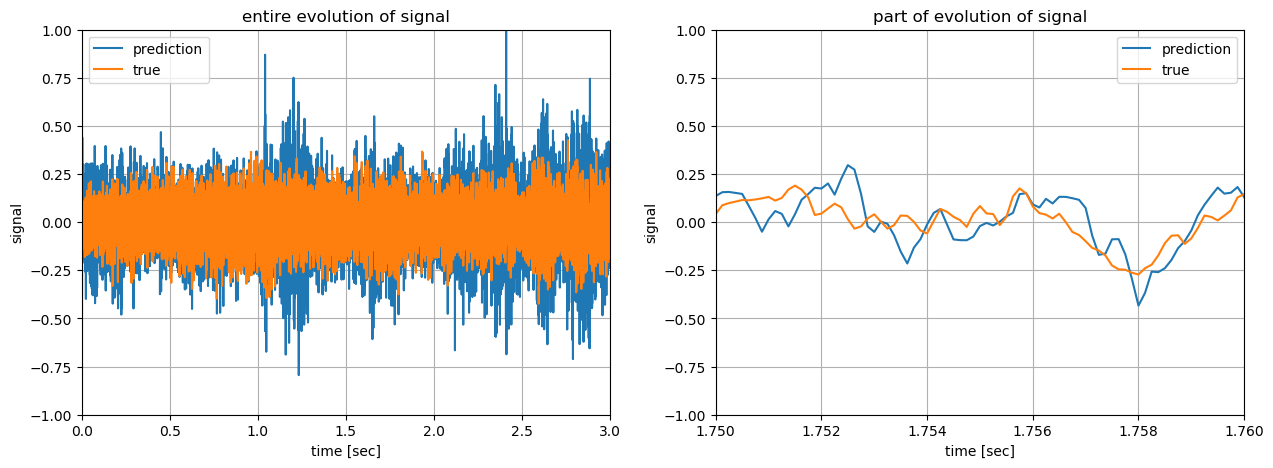

In [9]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t[1:end], x1_μ_pred[1:end], label="prediction"), ax[2].plot(t[1:end], x1_μ_pred[1:end], label="prediction")

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t[1:end], x_1[1:end], label="true"), ax[2].plot(t[1:end], x_1[1:end], label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1,1), ax[1].set_ylim(-1,1)

# create audioplayers
audioplayers(x_tot, x_1, x1_μ_pred, fs=fs_desired)
;

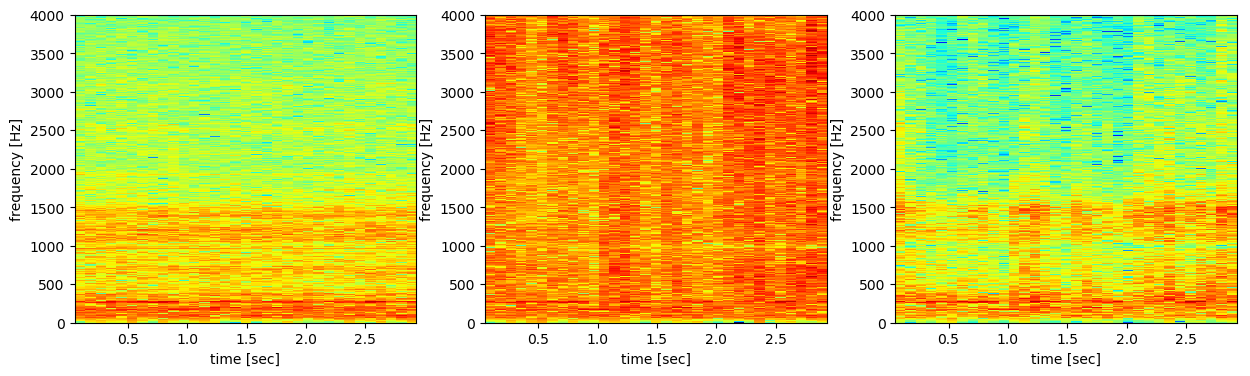

In [10]:
_, ax = plt.subplots(ncols=3, figsize=(15,4))
plot_spectrogram(spectrogram(x_1, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[1])
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(x1_μ_pred, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])
;

## Leaves 

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBJ90o922IpvbLjK76TKso9K1sgvuPnBD0N0gk+EI31vXWL071QGJu8wLEovvDdDT5sOwu+/6SJPp11S71C/ie9aXgIO5YCyj3CsGg8Ll12PeS+W77D7Uw9+KDsPd3BD75nwra9iRcMPv7KjT6PozC9P4f1vf34uDwgbgy+cb5zvdv2kr0dC569gFhIPWQeGz5JTxO+gDy+Pa0vB77JOaM+51JKPdU6zj2cF+U9Rk0KvrJ4Hj0B7ig9VKhaPF4KXrwTsAa8XV58PcWUWL5xfhG+tzjiPNqjbb05IqO7mJ0RPp2zsb0phoq9iyqHPLR8rz0xoaE9VFNgvr3MrL1cGiK8y8WQPFlirr1V8ey9pHM+PgSzYr5W2FU+Tkl9PbcGMz5/5Sy973JKPvnpB766Eg0+rukVvYlZBr6/dTs+LRu5vrC2ij77b+O9EYtwvQwao71viDy+S6JzvamfgT2f6Ri9TrZqPQNJJL61J+a70WCZvUhAPD6Xz6s9XKAJPOIESj06ngM+z5CtPYjHGL7CW00+y6VwPY2Fir7FeDy+Z+FcvXAnqT3/J9G9pRHpPU3Ojr4T66o9djHqPTTll77lKWI+Jr2pvYCXuT1XLfk9D7eQPvkeGT6+cHY93/wlPtcKLb5QGwE+714WPhOpjr7t/zA+23YsPdsSCz5s2hq+9BKyvbx0Tz4I+yW+3nabPiL6KD46ogy+dqiBvGZeHr4QAsM99EWOvhalbL35rwC9MguXvsi9Lz4w9p++o5XwPT1gw76yD/K794pkvg2kgr3oND6+m4MqvWIlmb1EFAi+6aN1PUEATT5xqQm9FztUPpVhjD34OTU+F+CgvX0o/bynl8Q+n96KPqe+VD6IabC+GpRsPnS6Ij83/ei+tTaYPWjknL5TTgC/QF+BP1a4Nr5kegW/zUPqPrTksz6fhEi/Q61OP0lV474Yqs4++1ECPr8+0b23/QO/6DHDP8YJGb9GhTi9ptI0PwhcqL4X7ZS954DlvugMUz5MEGO9BBDEPTw3ub4uhcc9quSLv4eTxD9Oemq/kzC5vs4WC74POyw/8/xGv4VtSj+mOUS/jFKcPoABKT55Fdy83YvavaoyJ76G2a4+FGEDv6YuYz+kVhS/XzbmPvbXsb50u8A9eNLGvnl1Ab6B0rs+zZuCvrycFz51Apm+t8vRvOPfwT7a4e++PNt2vkJmJT/J5p2/5pNsPspU2z6elhi+9RBQvyIFHz3bLt480tPbPo89PL5T6kY/wAtmv31sgD0JORM/sCO8vupJwj7SPq+9jGK+PmNAh7xlaJk+8rikvRNo/Tu6RIo9M5I5PWdQnT4hgFU9ELaTPsF3j723OeW9PCyvvcJVbrxr2i688IDlPZW/uL51q6G7Awv3vgjC6L2czlS9Neo+PmWilr3Yw1E+/A+NPmwQDr+DABc+3zPxvmKmqz5Qv4o9ZJraPvW/q70RKeW93FGZPCmyOT4gf7C99qWnPrLjWL6dpTa+LpGQvfF9sb6PnDy+Rw1NPmm4vL7lADk+p24svjJyOb6Mepw+F3wnvurjm70I+yy9IuiiPDGK+z0zbqs9DsGHPRM0Ur5USEg9l1Liun5SIL0zwm29tVIXPjq+Ib5O3Qk+nNa4vew6Dj45TBu+bWcbO3FMt71lQXI+2raFPAHPqzzZF1i91PmRPXPJsr270FO9hlYev1UiCz97XZW+fQ9QPyICqb2u4sM9U7O6PjDysj7/hQ0+YyZjPgeqkT23WsE+gLgmv/qRgT4mD/G8/qoFP+GuhT1HzWk+xl/9vrfJCD1doLo8aC1uPtOgO72gsom8lx1KvvVni71R/7a+ypYFPsZRPL+CEjk/+IyLvqDg377MCyo/QLgCvyM+sT6jKk2+K5/8Pg5SH78y3CA/Q5vjusyC1zyr7KK+MBuoPqR3Sz7oG8a94RkXPmIi5TyuFPu8migFv63OJz/Kgx+/MaeFPpGAgz75+IK/6VeCPixzw77pkZ0+zV/6vhp91j4ctva+oBsBv9+0Hb70exm9omyuPoI0Sr7+hIi8yw+Evu4Jo70SfQ4+EguLvUy6BD/f0Io+BNzUvvAzA71xaX+9pmkrPqqSpL4serc9txR1Pho8r75aV4E+zhCyvI43RT6hTjg8pP3DPvz1n76F7pi+thdFvpAghT4K6rO9oNRgPhn0A75rC9A+3cuUvpwomLwhOEU/0B26vutxjT6s4ig9cMLePqoeETwznuo+0KpqPv2YhD2qFuy9429LPWji171mFIU+DV92PmMAiTxjRaW+TJZNPNolnL4+iLi8Z6lwvMHHj74tVpO9MyQbPQWPDz4suA67an60vl/LPr8G5WM8zf07vRyEYL7eKJ29XgO1vulAhzxcX1c9d4UyPvoqLz6V1RU+r2lAPRYwa74lOyc+/+2/PmgfGD2/dC68ZvSSPLE9hb5Wwmq+4ir5vfCQvD3+TiG+ziQ4vo5xu76job++14cSPtAGRL4oijE+UliZPcZCTb7Zeso+H5+cPSBjJj5mTmC9VHmbPobrAz95IBy/yw0SP3R0Jj7ICws++9iNPuzelj6CHfE97KwgPrgKnz5bqaU9RdkKPiKbBD2eKJ++Oh8gvrNM0L3lAOO8OtDuvoMagT6XfiO/tOyEvhK0cT7Qo/8+YCa7viY39z6fTbq+fxaluqXBsz7xflO/c4vYPsUcir2iybm+2IwPPn59hz53a7w9F+ilvoww1D5moKe9mTiPvhfAJj7hFI0+hMMbvuqEXj2g19m7c/6nvv9zmr2vwRU/vN/wvnZVDj3B0RM/Cv7GvxW6UDzYtOU+uu5Av3jobD0BqQs+zshcPxTURb8L+Xw+ZbnSPv5wmb5u39g9++4MPkPXBr9dGkM/sjHcPbPxsb2qspe+E28SP46cCL1f68u9jRowP4iZ875iDoQ+Ia5KvdWiMb4NNx48ZuWIvRqtx7544YC+NUTGvnrZKb7knqq94bSMPv/IQT6OVwq+6nWIPwqlXr+fWFE+qkgLu7hXGr4Hkzo9/Y9wPTuRCj9LQjG8RLzxPkhnpj4vZjQ9SI6Mvc39K76Z2JO9ChIivhuhFT6WHwg+FG53PRmlUb2orta9SJpXvgZstr1R5WK+lAdJvlpykL75JQ2+rPt+P2rG477hM+w+jpuVvm7FiT9s3WC+tmYnPlMSIj9bwYa/7w7APrFZOb75AeW+GAhnvl3f8D5BXg4+gaA2v39X0T2bgxy+e4ikPot1ib2rJz++Oo8BvxlI3r6/1y4+vNJav+YmET8zrVo+LakrvxBmSj7LHbY8CuUCP+1567537Jc+zhWCPqPq8z1bnRK/7A69PkEztj6QLjS/0Mg4P3Ocsj5cGlO/64cCPsfWEj+GjNm+W6M5vhfsTz7eqn29hY8Bv7MrrL6l7RY/6TpGvz4acD/GUvA7S4YOPzV8Zr6LZos8+ozuPbgjvb6YryE/jUxUvu71Tb4nyxQ9rzSWvvNdL75VA5k+8jrCPd1ksLyMM30+X5t1PmJLk74ftcY+oweyO2uFdb47ls0+6KW6PnYtmD0nMuc9NmvhvW/kQb2j0t299TmFPuwwsj58Rwa/jy2PPjsFij4c2L2+r1krP2WTuTkyDYe/kwAOP7AxFT1ZDhi8GNcmPj4heb6CdsO+sBSxvoJKoD6qulG+bwZ+P7TZmL71KdS9yy4Av1gSY77icBy/Q0LEPvQjjr0TBR2/+bpnP5HGzb7zz6o6eZYnP7KMu75pdFq+yLWBv0sk8z1OI1+/FRB9vtdExz5HFZ2+fPxMPRwz4T5mlgM/7SYUvDfS5r3IorY+o3d2O6GgKT77lB0+lnhwPRifQ75a6aa+/x6KPaDCZj42RhS/wxzQPmqqyj3tMnU93UczP704Eb4GX

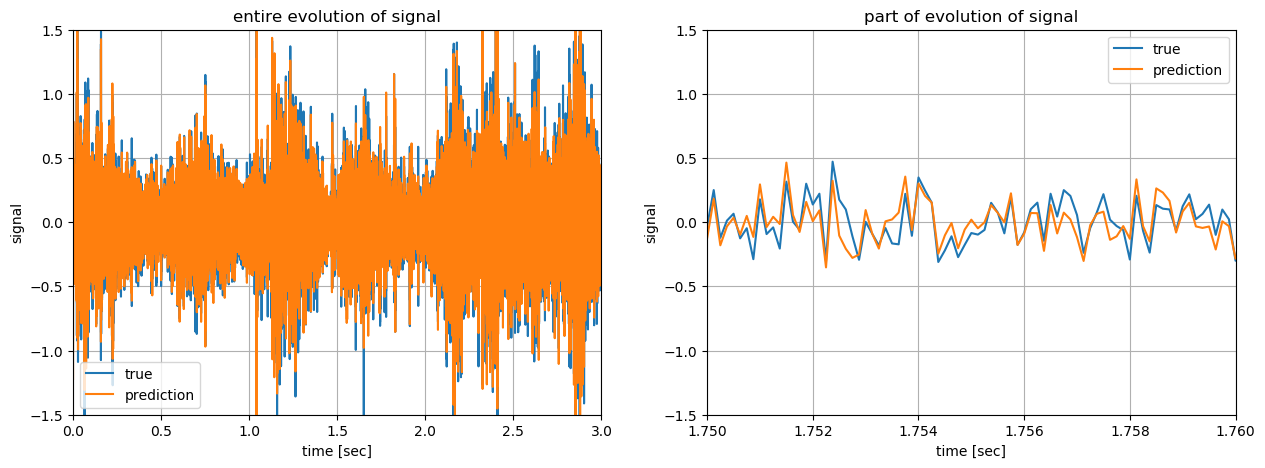

In [11]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))


# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_2, label="true"), ax[2].plot(t, x_2, label="true") 
# plot prediction of frequency component
ax[1].plot(t, x2_μ_pred, label="prediction"), ax[2].plot(t, x2_μ_pred, label="prediction")

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(1.75, 1.76), ax[2].set_ylim(-1.5,1.5), ax[1].set_ylim(-1.5,1.5)

# create audioplayers
audioplayers(x_tot, x_2, x2_μ_pred, fs=fs_desired)
;

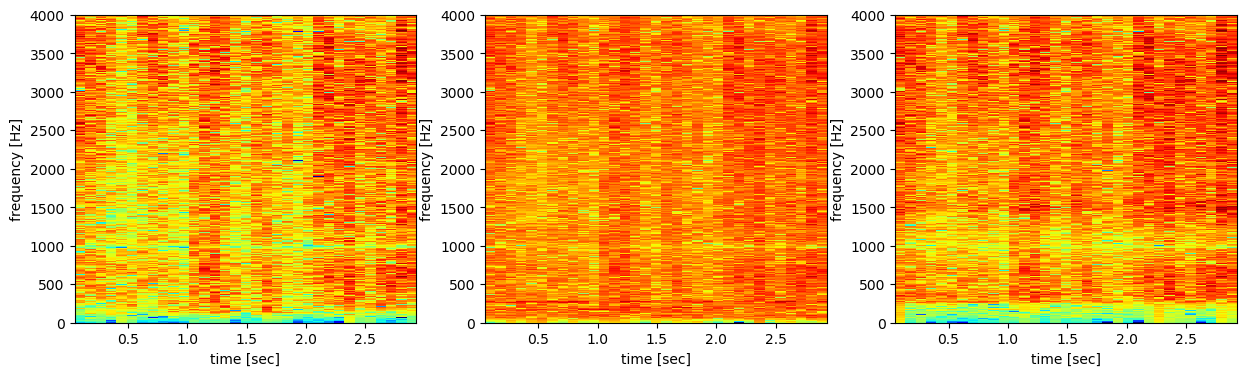

In [12]:
_, ax = plt.subplots(ncols=3, figsize=(15,4))
plot_spectrogram(spectrogram(x_2, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[1])
plot_spectrogram(spectrogram(x_tot, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])
plot_spectrogram(spectrogram(x2_μ_pred, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[3])
;